<a href="https://colab.research.google.com/github/rich-hyun/5th-Static-Competition/blob/main/static_jaehyun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. 데이터 불러오기

In [ ]:
!pip install scikit-learn
!pip install lightgbm xgboost

In [1]:
import json
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from google.colab import files
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras.layers import Dense, LSTM, GRU, Dropout
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop, Adagrad, Adamax
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
#데이터 로드 및 시각화
url = "https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/main/Urban%20Air%20Quality%20and%20Health%20Impact%20Dataset.csv"
df = pd.read_csv(url)

df.head()

datetime  datetimeEpoch  tempmax  tempmin  temp  feelslikemax  \
0  2024-09-07     1725692400    106.1     91.0  98.5         104.0   
1  2024-09-08     1725778800    103.9     87.0  95.4         100.5   
2  2024-09-09     1725865200    105.0     83.9  94.7          99.9   
3  2024-09-10     1725951600    106.1     81.2  93.9         100.6   
4  2024-09-11     1726038000    106.1     82.1  94.0         101.0   

   feelslikemin  feelslike   dew  humidity  ...     City  Temp_Range  \
0          88.1       95.9  51.5      21.0  ...  Phoenix        15.1   
1          84.7       92.3  48.7      21.5  ...  Phoenix        16.9   
2          81.6       90.6  41.7      16.9  ...  Phoenix        21.1   
3          79.5       89.8  39.1      15.7  ...  Phoenix        24.9   
4          80.0       90.0  40.1      15.9  ...  Phoenix        24.0   

   Heat_Index Severity_Score  Condition_Code  Month  Season  Day_of_Week  \
0   95.918703         4.4300             NaN      9    Fall     Saturday   
1   92.281316         3.8800             0.0      9    Fall       Sunday   
2   90.599165         3.6300             0.0      9    Fall       Monday   
3   89.638811         2.8512             0.0      9    Fall      Tuesday   
4   89.760414         3.3908             0.0      9    Fall    Wednesday   

   Is_Weekend  Health_Risk_Score  
0        True          10.522170  
1        True          10.062332  
2       False           9.673387  
3       False           9.411519  
4       False           9.515179  

[5 rows x 46 columns]

In [ ]:
# 추가로 제외할 컬럼들 설정 및 모델 정확도 측정 코드 작성
features_updated = df.drop(columns = ['datetime', 'sunrise', 'sunset', 'preciptype', 'snowdepth', 'stations', 'Condition_Code',
                                      'Health_Risk_Score' ,'conditions', 'description', 'icon', 'source', 'City', 'Season',
                                      'Day_of_Week', 'datetimeEpoch', 'feelslikemin', 'precipprob', 'solarenergy', 'uvindex',
                                      'sunriseEpoch', 'sunsetEpoch', 'moonphase', 'Heat_Index', 'Is_Weekend'])
target = df['Health_Risk_Score']
X_train_updated, X_test_updated, y_train_updated, y_test_updated = train_test_split(features_updated, target, test_size=0.2, random_state=29)
scaler_updated = StandardScaler()
X_train_scaled_updated = scaler_updated.fit_transform(X_train_updated)
X_test_scaled_updated = scaler_updated.transform(X_test_updated)

# 랜덤 포레스트 모델
rf_model_updated = RandomForestRegressor(n_estimators=120, random_state=29)
rf_model_updated.fit(X_train_scaled_updated, y_train_updated)
y_pred_rf_updated = rf_model_updated.predict(X_test_scaled_updated)

# 정확도 측정
mae_rf_updated = mean_absolute_error(y_test_updated, y_pred_rf_updated)
r2_rf_updated = r2_score(y_test_updated, y_pred_rf_updated)
mae_rf_updated, r2_rf_updated

(0.08613055937354183, 0.9654342969476132)

##1.1 선형회귀 모델을 쓰지 못하는 이유

In [ ]:
#상관관계 계산
numeric_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()
health_risk_corr_sorted = correlation_matrix["Health_Risk_Score"].sort_values(ascending=False)
print(health_risk_corr_sorted)

Health_Risk_Score    1.000000
Heat_Index           0.610722
Severity_Score       0.585555
windgust             0.583670
dew                  0.581391
severerisk           0.524030
feelslike            0.522430
feelslikemax         0.518574
windspeed            0.487805
feelslikemin         0.454905
tempmin              0.434786
temp                 0.412288
tempmax              0.354713
precipprob           0.321389
precipcover          0.284049
humidity             0.186211
uvindex              0.173279
precip               0.143755
cloudcover           0.136964
solarradiation       0.085156
solarenergy          0.081934
Temp_Range          -0.056190
moonphase           -0.106345
sunriseEpoch        -0.108654
datetimeEpoch       -0.111190
sunsetEpoch         -0.115130
visibility          -0.176669
winddir             -0.183140
pressure            -0.297056
snow                      NaN
snowdepth                 NaN
Condition_Code            NaN
Month                     NaN
Name: Heal

In [ ]:
#변수들 간의 상관관계 확인->다중공정성 문제 발생
selected_features = ['Heat_Index', 'Severity_Score', 'windgust', 'dew', 'severerisk',
                     'feelslike', 'feelslikemax', 'windspeed', 'feelslikemin',
                     'tempmin', 'temp']
selected_corr_matrix = df[selected_features].corr()
print(selected_corr_matrix)

                Heat_Index  Severity_Score  windgust       dew  severerisk  \
Heat_Index        1.000000        0.294434  0.259991  0.072294    0.486072   
Severity_Score    0.294434        1.000000  0.862801 -0.038384    0.073273   
windgust          0.259991        0.862801  1.000000  0.132921    0.082172   
dew               0.072294       -0.038384  0.132921  1.000000    0.392131   
severerisk        0.486072        0.073273  0.082172  0.392131    1.000000   
feelslike         0.827673        0.267552  0.280502  0.288758    0.427733   
feelslikemax      0.815434        0.247352  0.230291  0.262477    0.408079   
windspeed         0.186978        0.689536  0.718891  0.044377    0.073634   
feelslikemin      0.740163        0.230200  0.260073  0.290646    0.387913   
tempmin           0.738725        0.226903  0.251239  0.258251    0.366885   
temp              0.800903        0.275709  0.275448  0.150877    0.343067   

                feelslike  feelslikemax  windspeed  feelslikemi

##1.2 변수들 설명

<ipython-input-7-20e7a77fb7a4>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='plasma')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1

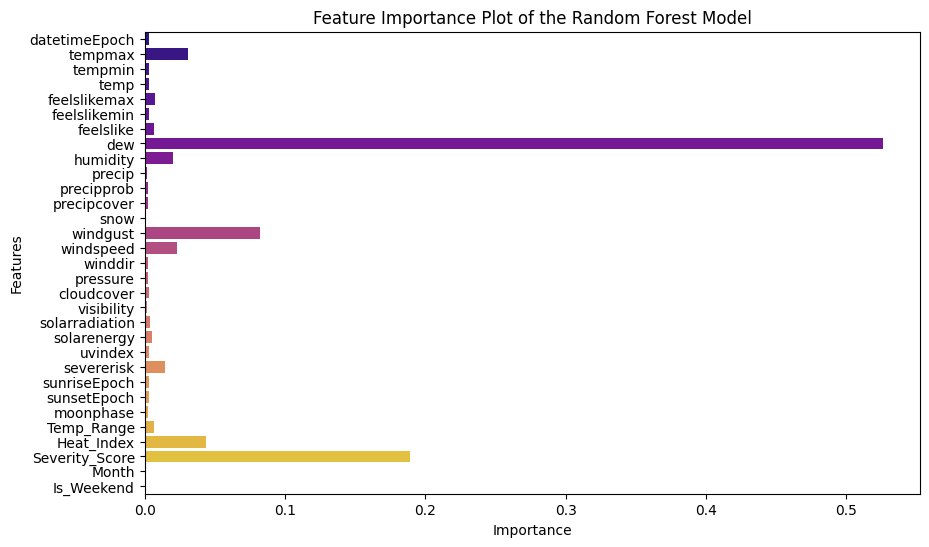

In [ ]:
# 랜덤 포레스트 모델 변수 중요도
features = df.drop(columns = ['datetime', 'sunrise', 'sunset', 'preciptype', 'snowdepth', 'stations', 'Condition_Code', 'Health_Risk_Score' ,'conditions', 'description', 'icon', 'source', 'City', 'Season', 'Day_of_Week'])
target = df['Health_Risk_Score']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=29)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestRegressor(n_estimators=120, random_state=29)
rf_model.fit(X_train_scaled, y_train)

importances = rf_model.feature_importances_
feature_names = X_train.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names, palette='plasma')
plt.title('Feature Importance Plot of the Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

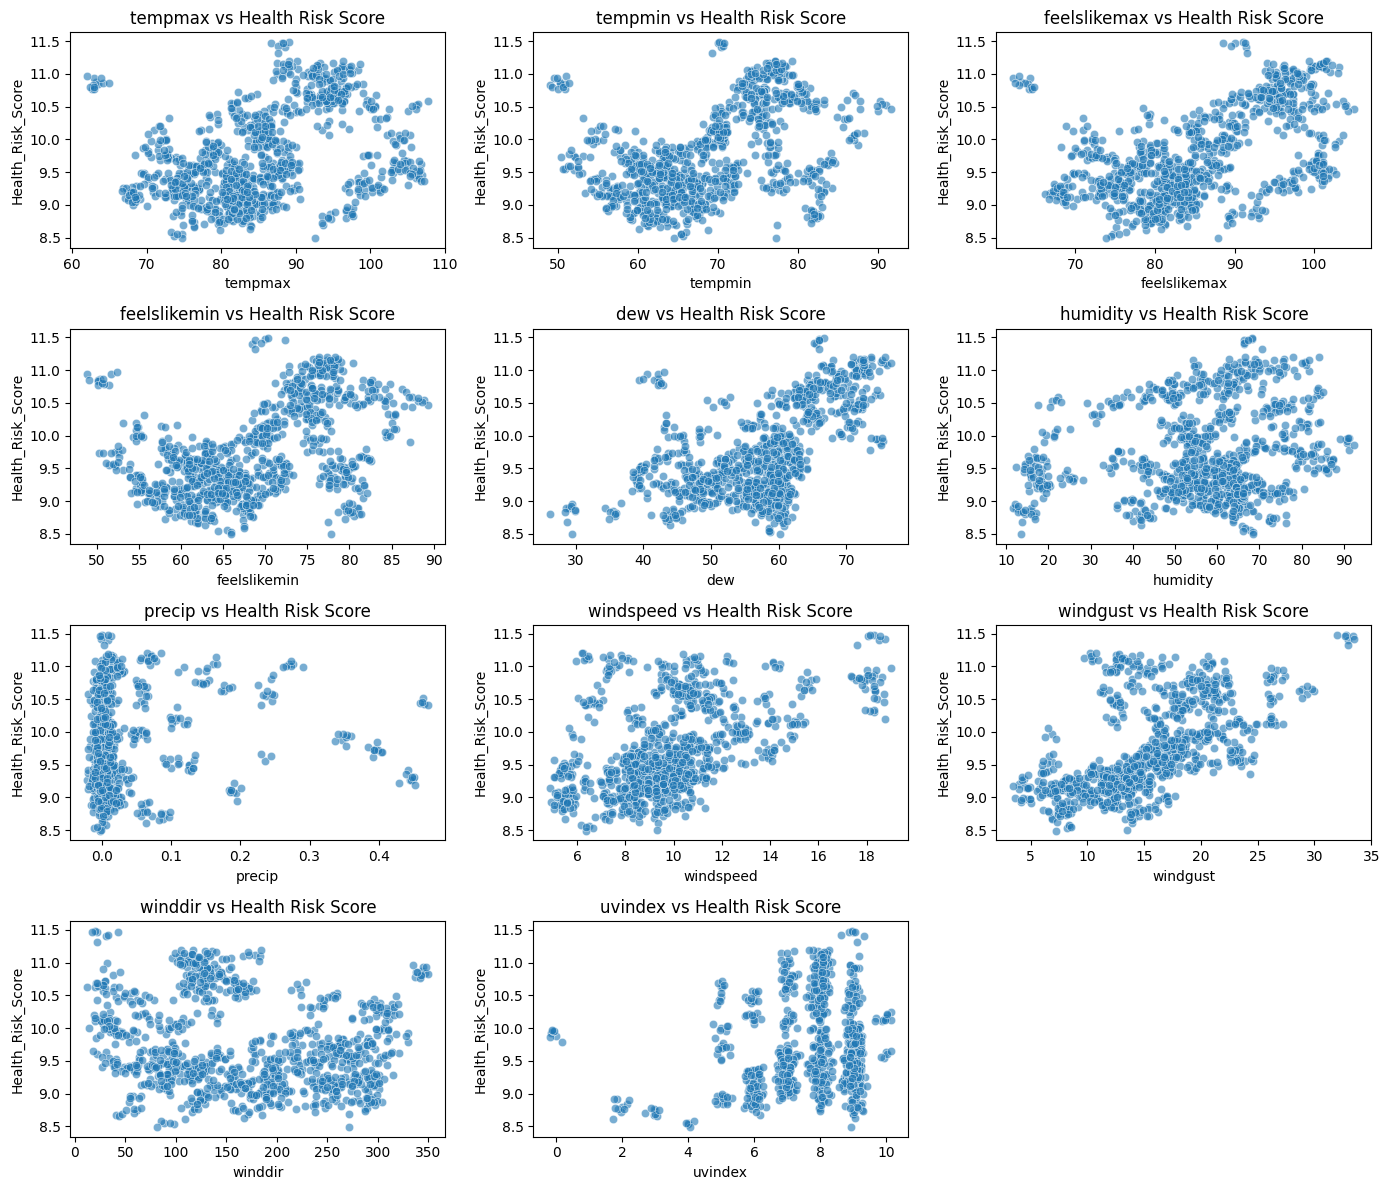

In [ ]:
# 각 변수의 분포도와 Health Risk Score의 관계를 시각화하는 코드
plt.figure(figsize=(14, 12))

selected_features = ['tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'dew',
                     'humidity', 'precip', 'windspeed', 'windgust', 'winddir', 'uvindex']

for i, feature in enumerate(selected_features, 1):
    plt.subplot(4, 3, i)
    sns.scatterplot(x=df[feature], y=df['Health_Risk_Score'], alpha=0.6)
    plt.title(f'{feature} vs Health Risk Score')

plt.tight_layout()
plt.show()

#2. 모델 제작

##2.1 랜덤포레스트 모델

In [ ]:
#선별된 데이터의 randomforest 결과

features = df.drop(columns = ['datetime', 'sunrise', 'sunset', 'preciptype', 'snowdepth', 'stations', 'Condition_Code', 'Health_Risk_Score' ,'conditions', 'description', 'icon', 'source', 'City', 'Season', 'Day_of_Week'])
target = df['Health_Risk_Score']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=29)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestRegressor(n_estimators=120, random_state=29)
rf_model.fit(X_train_scaled, y_train)

rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

y_pred_rf
y_test
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf, r2_rf

(0.08533279983758309, 0.9674450275362524)

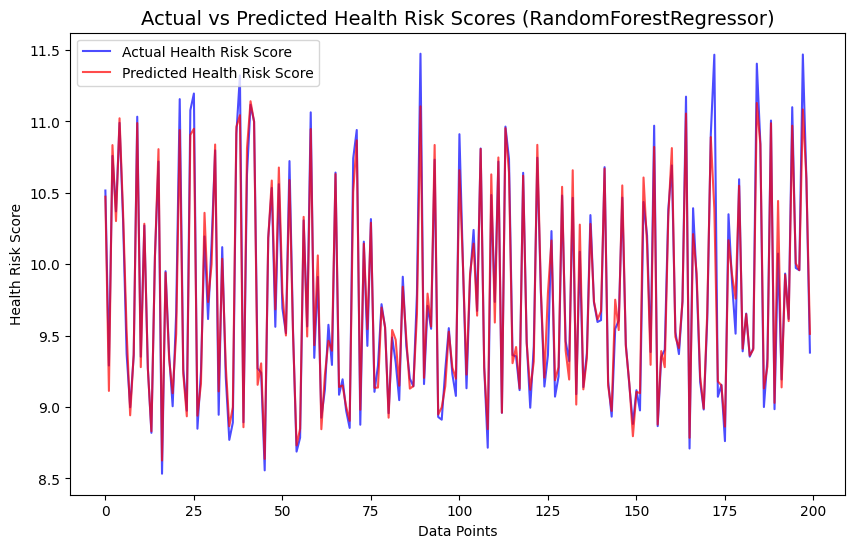

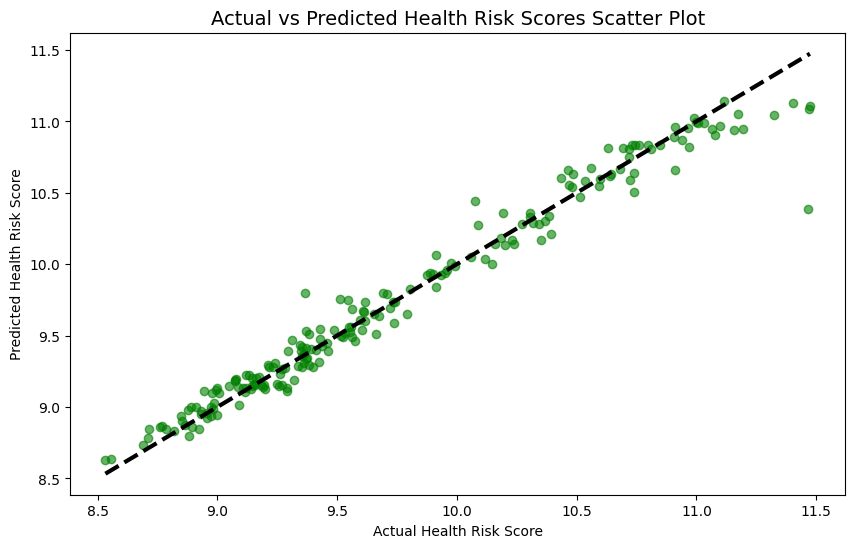

In [ ]:
#실제 값과 예상치 차이 출력

plt.figure(figsize=(10, 6))

plt.plot(np.arange(len(y_test)), y_test, label='Actual Health Risk Score', color='blue', alpha=0.7)
plt.plot(np.arange(len(y_test)), y_pred_rf, label='Predicted Health Risk Score', color='red', alpha=0.7)

plt.title('Actual vs Predicted Health Risk Scores (RandomForestRegressor)', fontsize=14)
plt.xlabel('Data Points')
plt.ylabel('Health Risk Score')
plt.legend()

plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)

plt.title('Actual vs Predicted Health Risk Scores Scatter Plot', fontsize=14)
plt.xlabel('Actual Health Risk Score')
plt.ylabel('Predicted Health Risk Score')

plt.show()

##2.2 XGBoost, GradientBoost, LightGBM, 랜덤포레스트 결과값 비교

In [ ]:
# XGBoost, GradientBoost, LightGBM, 랜덤포레스트 결과값 비교
features = df.drop(columns = ['datetime', 'sunrise', 'sunset', 'preciptype', 'snowdepth', 'stations', 'Condition_Code', 'Health_Risk_Score' ,'conditions', 'description', 'icon', 'source', 'City', 'Season', 'Day_of_Week'])
target = df['Health_Risk_Score']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=29)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LightGBM 모델
lgbm_model = LGBMRegressor(random_state=29)
lgbm_model.fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm_model.predict(X_test_scaled)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

# XGBoost 모델
xgb_model = XGBRegressor(random_state=29)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# GradientBoosting 모델
gbr_model = GradientBoostingRegressor(random_state=29)
gbr_model.fit(X_train_scaled, y_train)
y_pred_gbr = gbr_model.predict(X_test_scaled)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

results = {
    'RandomForest': {'MAE': mae_rf, 'R²': r2_rf},
    'LightGBM': {'MAE': mae_lgbm, 'R²': r2_lgbm},
    'XGBoost': {'MAE': mae_xgb, 'R²': r2_xgb},
    'GradientBoosting': {'MAE': mae_gbr, 'R²': r2_gbr}
}

print(json.dumps(results, indent=4))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7143
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 29
[LightGBM] [Info] Start training from score 9.719476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

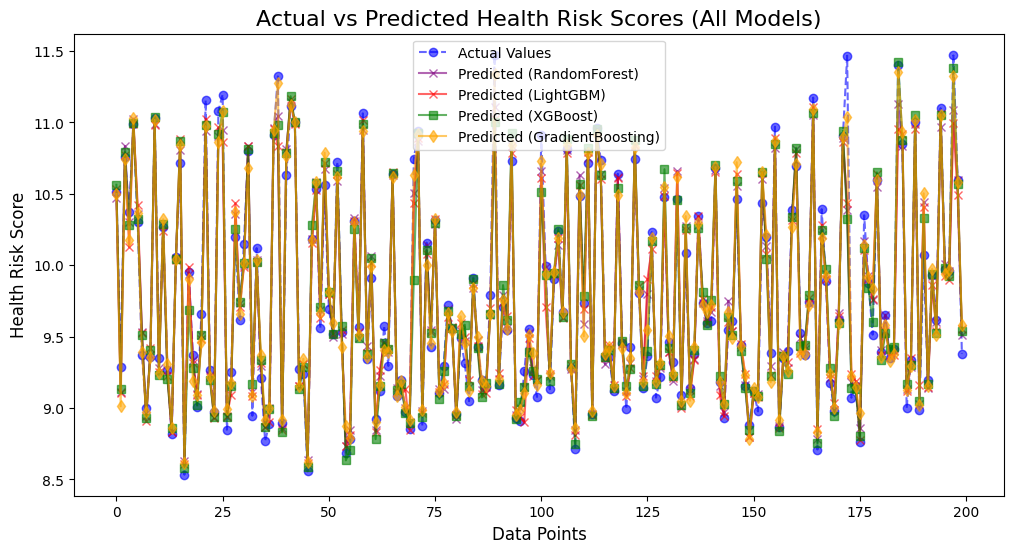

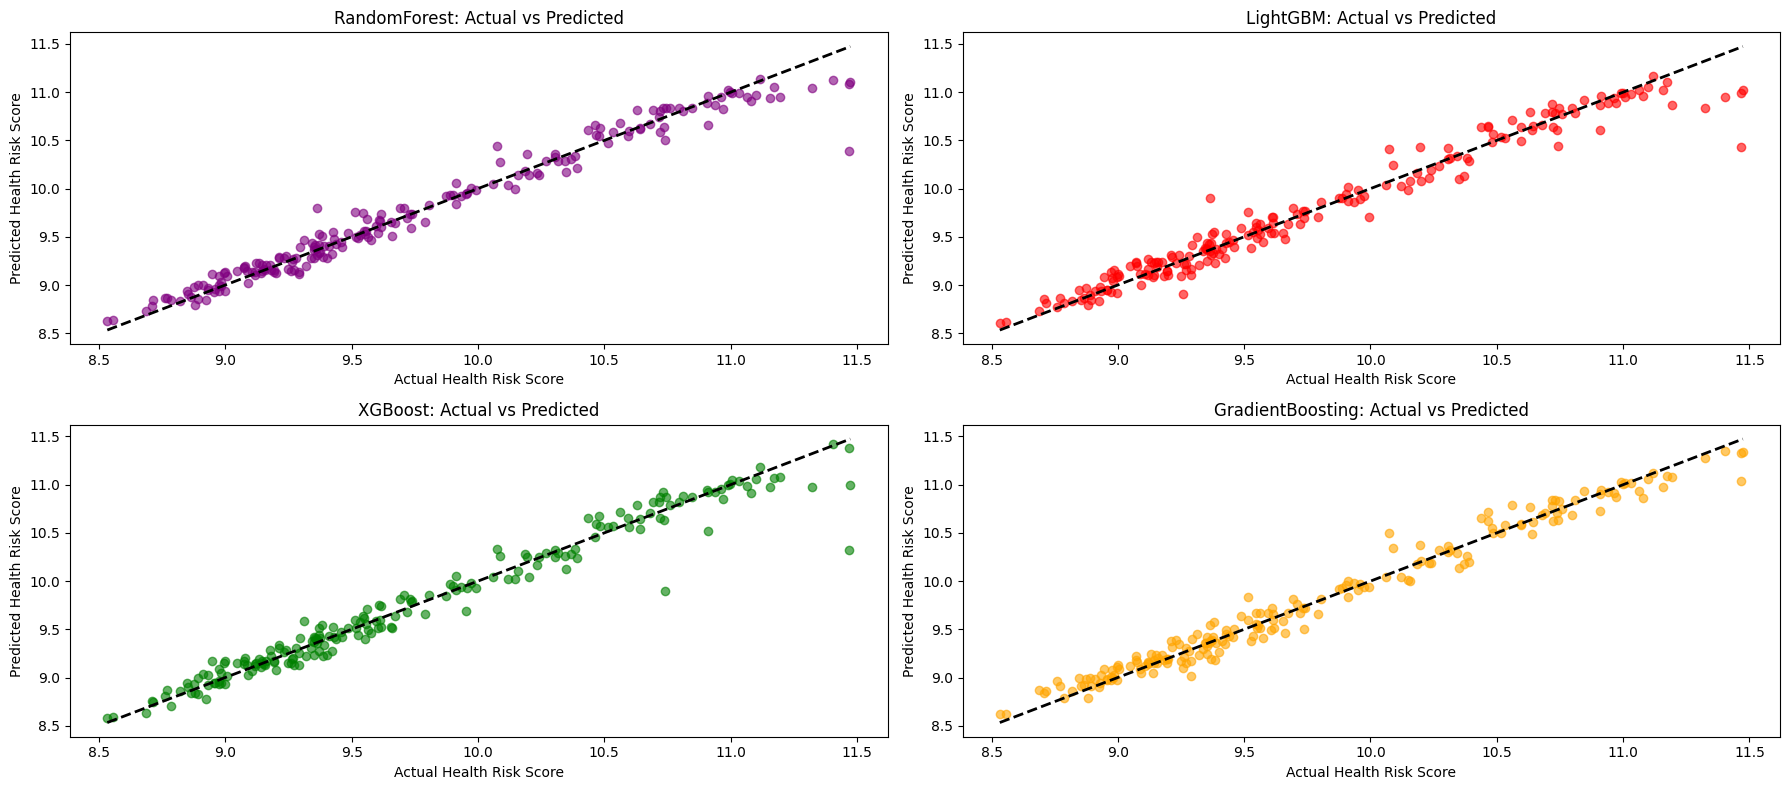

In [ ]:
#데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_test)), y_test, label='Actual Values', color='blue', linestyle='--', marker='o', alpha=0.6)
plt.plot(np.arange(len(y_test)), y_pred_rf, label='Predicted (RandomForest)', color='purple', linestyle='-', marker='x', alpha=0.6)
plt.plot(np.arange(len(y_test)), y_pred_lgbm, label='Predicted (LightGBM)', color='red', linestyle='-', marker='x', alpha=0.6)
plt.plot(np.arange(len(y_test)), y_pred_xgb, label='Predicted (XGBoost)', color='green', linestyle='-', marker='s', alpha=0.6)
plt.plot(np.arange(len(y_test)), y_pred_gbr, label='Predicted (GradientBoosting)', color='orange', linestyle='-', marker='d', alpha=0.6)

plt.title('Actual vs Predicted Health Risk Scores (All Models)', fontsize=16)
plt.xlabel('Data Points', fontsize=12)
plt.ylabel('Health Risk Score', fontsize=12)
plt.legend()
plt.show()

plt.figure(figsize=(18, 8))

# RandomForest
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred_rf, color='purple', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('RandomForest: Actual vs Predicted')
plt.xlabel('Actual Health Risk Score')
plt.ylabel('Predicted Health Risk Score')

# LightGBM
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred_lgbm, color='red', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('LightGBM: Actual vs Predicted')
plt.xlabel('Actual Health Risk Score')
plt.ylabel('Predicted Health Risk Score')

# XGBoost
plt.subplot(2, 2, 3)
plt.scatter(y_test, y_pred_xgb, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('XGBoost: Actual vs Predicted')
plt.xlabel('Actual Health Risk Score')
plt.ylabel('Predicted Health Risk Score')

# GradientBoosting
plt.subplot(2, 2, 4)
plt.scatter(y_test, y_pred_gbr, color='orange', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('GradientBoosting: Actual vs Predicted')
plt.xlabel('Actual Health Risk Score')
plt.ylabel('Predicted Health Risk Score')

plt.tight_layout()
plt.show()

#3. Gradient Boost 모델 정확도 개선

##3.1 하이퍼파라미터 튜닝

In [ ]:
# Gradient Boosting 모델 하이퍼파라미터 튜닝
gbr = GradientBoostingRegressor(random_state=29)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],          # 학습률
    'n_estimators': [100, 200, 500],             # 트리 개수
    'max_depth': [3, 5, 7],                      # 트리 최대 깊이
    'subsample': [0.8, 1.0],                     # 서브샘플링 비율
    'min_samples_split': [2, 5, 10]              # 노드를 분할하는 데 필요한 최소 샘플 수
}

grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

best_gbr_model = grid_search.best_estimator_
y_pred_best_gbr = best_gbr_model.predict(X_test_scaled)

mae_best_gbr = mean_absolute_error(y_test, y_pred_best_gbr)
r2_best_gbr = r2_score(y_test, y_pred_best_gbr)

print(f"MAE (Best Model): {mae_best_gbr}")
print(f"R² (Best Model): {r2_best_gbr}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 500, 'subsample': 0.8}
Best score: -0.011368686193843935
MAE (Best Model): 0.08188760512606452
R² (Best Model): 0.9742289525434393


##3.2 스케일링

In [ ]:
# 데이터 스케일링
features = df.drop(columns = ['datetime', 'sunrise', 'sunset', 'preciptype', 'snowdepth', 'stations', 'Condition_Code', 'Health_Risk_Score' ,'conditions', 'description', 'icon', 'source', 'City', 'Season', 'Day_of_Week','Severity_Score',
'severerisk', 'visibility', 'cloudcover', 'precipcover','Month'])
target = df['Health_Risk_Score']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=29)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LightGBM 모델
lgbm_model = LGBMRegressor(random_state=29)
lgbm_model.fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm_model.predict(X_test_scaled)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

# XGBoost 모델
xgb_model = XGBRegressor(random_state=29)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# GradientBoosting 모델
gbr_model = GradientBoostingRegressor(random_state=29)
gbr_model.fit(X_train_scaled, y_train)
y_pred_gbr = gbr_model.predict(X_test_scaled)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

# 결과 출력
results = {
    'RandomForest': {'MAE': mae_rf, 'R²': r2_rf},
    'LightGBM': {'MAE': mae_lgbm, 'R²': r2_lgbm},
    'XGBoost': {'MAE': mae_xgb, 'R²': r2_xgb},
    'GradientBoosting': {'MAE': mae_gbr, 'R²': r2_gbr}
}

print(json.dumps(results, indent=4))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5868
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 24
[LightGBM] [Info] Start training from score 9.719476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

#4. 제작된 모델로 데이터 제작

##4.1 파일 업로드 시 데이터 제작

In [ ]:
#파일 업로드 후 결측치 확인
uploaded = files.upload()
df_uploaded = pd.read_csv(list(uploaded.keys())[0])
print("Uploaded file preview:")
df_uploaded.head()

Saving Ulrung001.csv to Ulrung001.csv
Uploaded file preview:


datatime   temp  tempmin  tempmax    precip   windgust  winddir  \
0  2014-01-01  41.54    37.22    44.78  0.003937  20.132460      230   
1  2014-01-02  38.30    34.52    44.24  0.000000  17.448132       50   
2  2014-01-03  43.34    36.86    47.66  0.000000  15.882274      230   
3  2014-01-04  31.82    30.38    43.70  0.019685  23.264176       50   
4  2014-01-05  32.36    31.28    34.52  1.188977  16.777050       50   

   windspeed  dew  humiditymin  humidity  pressure  solarradiation       snow  \
0  10.513618 -9.0         24.0      35.5     983.3             NaN   4.724412   
1   6.934514 -3.7         32.0      59.3     991.3             NaN   2.755907   
2   9.842536 -5.4         32.0      43.3     987.7             NaN   1.574804   
3  17.000744 -3.9         48.0      75.5     991.4             NaN   0.393701   
4   8.276678 -2.6         66.0      82.0     994.5             NaN  11.811030   

   Temp_Range  feelslike  feelslikemax  feelslikemin  
0        7.56  35.342020     39.373868     29.966224  
1        9.72  33.128883     40.282258     28.576735  
2       10.80  37.845366     43.192914     29.824044  
3       13.32  20.667253     36.042156     18.803628  
4        3.24  25.117658     27.755030     23.798972

In [ ]:
# 숫자형 열만 선택하여 결측치를 각 열의 평균값으로 대체
print("\n결측치 확인:")
missing_values = df_uploaded.isnull().sum()
print(missing_values)

print("\n결측치를 각 열의 평균값으로 대체 중...")
numeric_columns = df_uploaded.select_dtypes(include=['float64', 'int64']).columns
df_uploaded[numeric_columns] = df_uploaded[numeric_columns].fillna(df_uploaded[numeric_columns].mean())
print("\n결측치 처리 후:")
print(df_uploaded.isnull().sum())
print("\n처리된 데이터프레임 미리보기:")
print(df_uploaded.head())


결측치 확인:
datatime             0
temp                 2
tempmin              1
tempmax              0
precip               0
windgust             1
winddir              0
windspeed            3
dew                  3
humiditymin          2
humidity             7
pressure             3
solarradiation    1005
snow                 0
Temp_Range           1
feelslike            5
feelslikemax         3
feelslikemin         3
dtype: int64

결측치를 각 열의 평균값으로 대체 중...

결측치 처리 후:
datatime          0
temp              0
tempmin           0
tempmax           0
precip            0
windgust          0
winddir           0
windspeed         0
dew               0
humiditymin       0
humidity          0
pressure          0
solarradiation    0
snow              0
Temp_Range        0
feelslike         0
feelslikemax      0
feelslikemin      0
dtype: int64

처리된 데이터프레임 미리보기:
     datatime   temp  tempmin  tempmax    precip   windgust  winddir  \
0  2014-01-01  41.54    37.22    44.78  0.003937  20.132460      

In [ ]:
# 데이터 업로드시 Predicted_Health_Risk_score 출력
uploaded = files.upload()
df_uploaded = pd.read_csv(list(uploaded.keys())[0])
numeric_columns = df_uploaded.select_dtypes(include=['float64', 'int64']).columns
df_uploaded[numeric_columns] = df_uploaded[numeric_columns].fillna(df_uploaded[numeric_columns].mean())
url_dataset = "https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/main/Urban%20Air%20Quality%20and%20Health%20Impact%20Dataset.csv"
df = pd.read_csv(url_dataset)
features = df[['temp', 'tempmin', 'tempmax', 'precip', 'windgust', 'winddir', 'windspeed', 'dew',
               'humidity', 'pressure', 'solarradiation', 'Temp_Range', 'feelslike', 'feelslikemax']]
target = df['Health_Risk_Score']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=29)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
gb_model = GradientBoostingRegressor(random_state=29)
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5,
                           scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
best_gb_model = grid_search.best_estimator_
df_uploaded.columns = df_uploaded.columns.str.strip()
features_uploaded = df_uploaded[['temp', 'tempmin', 'tempmax', 'precip', 'windgust', 'winddir', 'windspeed', 'dew',
                                 'humidity', 'pressure', 'solarradiation', 'snow', 'Temp_Range', 'feelslike', 'feelslikemax']]
features_uploaded_scaled = scaler.transform(features_uploaded)
# Health_Risk_Score 예측
df_uploaded['Predicted_Health_Risk_Score'] = best_gb_model.predict(features_uploaded_scaled)
output_file_optimized_gb = 'Health_Risk_Predictions_Optimized_GB.xlsx'
df_uploaded.to_excel(output_file_optimized_gb, index=False)
# 엑셀 파일 다운로드
files.download(output_file_optimized_gb)

Saving Gangneung001.csv to Gangneung001 (3).csv
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 500, 'subsample': 0.8}
Best score: -0.012758033208315023


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- snow


#5.다변량 시계열 LSTM GRU 모델 제작

## 20% 랜덤 추출 후 모델 제작

In [2]:
#LSTM과 GRU 모델 제작
url = "https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/refs/heads/main/seoul2.csv"
df = pd.read_csv(url)
features = ['temp', 'tempmin', 'tempmax', 'precip', 'windgust', 'winddir', 'windspeed', 'dew',
            'humidity', 'pressure', 'solarradiation', 'snow', 'Temp_Range', 'feelslike',
            'feelslikemax']

target = 'Predicted_Health_Risk_Score'
df = df.dropna()
X = df[features]
y = df[target]
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model
def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model
lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
gru_model = create_gru_model((X_train.shape[1], X_train.shape[2]))
gru_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
y_pred_lstm = lstm_model.predict(X_test)
y_pred_gru = gru_model.predict(X_test)
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm)
y_pred_gru = scaler_y.inverse_transform(y_pred_gru)
y_test = scaler_y.inverse_transform(y_test)
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mae, mse, rmse, r2
lstm_metrics = calculate_metrics(y_test, y_pred_lstm)
gru_metrics = calculate_metrics(y_test, y_pred_gru)
metrics_df = pd.DataFrame({
    "Model": ["LSTM", "GRU"],
    "MAE": [lstm_metrics[0], gru_metrics[0]],
    "MSE": [lstm_metrics[1], gru_metrics[1]],
    "RMSE": [lstm_metrics[2], gru_metrics[2]],
})

print(metrics_df)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


NameError: name 'r2' is not defined

In [ ]:
# 옵티마이저 활용
url = 'https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/refs/heads/main/Seoul%2014%7E23.csv'
df = pd.read_csv(url)
features = ['temp', 'tempmin', 'tempmax', 'precip', 'windgust', 'winddir', 'windspeed', 'dew',
            'humidity', 'pressure', 'solarradiation', 'snow', 'Temp_Range', 'feelslike',
            'feelslikemax', 'heat_index']
target = 'Predicted_Health_Risk_Score'
df = df.dropna()

X = df[features]
y = df[target]
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
def create_lstm_model(input_shape, optimizer):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model
def create_gru_model(input_shape, optimizer):
    model = Sequential()
    model.add(GRU(50, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2
optimizer_classes = {
    "RMSProp": RMSprop,
    "Adagrad": Adagrad,
    "Adamax": Adamax
}
results = {}
for opt_name, optimizer_class in optimizer_classes.items():
    print(f"\nTraining with {opt_name} optimizer...")
    optimizer = optimizer_class()
    lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]), optimizer)
    lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
    optimizer = optimizer_class()
    gru_model = create_gru_model((X_train.shape[1], X_train.shape[2]), optimizer)
    gru_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
    y_pred_lstm = lstm_model.predict(X_test)
    y_pred_gru = gru_model.predict(X_test)
    y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm)
    y_pred_gru = scaler_y.inverse_transform(y_pred_gru)
    y_test_unscaled = scaler_y.inverse_transform(y_test)
    lstm_metrics = calculate_metrics(y_test_unscaled, y_pred_lstm)
    gru_metrics = calculate_metrics(y_test_unscaled, y_pred_gru)
    results[opt_name] = {
        "LSTM": lstm_metrics,
        "GRU": gru_metrics
    }
for opt_name, metrics in results.items():
    print(f"\nResults for {opt_name}:")
    print(f"LSTM - MAE: {metrics['LSTM'][0]}, MSE: {metrics['LSTM'][1]}, RMSE: {metrics['LSTM'][2]}")
    print(f"GRU - MAE: {metrics['GRU'][0]}, MSE: {metrics['GRU'][1]}, RMSE: {metrics['GRU'][2]}")


Training with RMSProp optimizer...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Training with Adagrad optimizer...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step

Training with Adamax optimizer...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Results for RMSProp:
LSTM - MAE: 0.14270333159392304, MSE: 0.03282048634092197, RMSE: 0.18116425238142864, R2: 0.6155572918550237
GRU - MAE: 0.14650688482803753, MSE: 0.034370748605891586, RMSE: 0.18539349666558314, R2: 0.5973982975826938

Results for Adagrad:
LSTM - MAE: 0.2758154392769864, MSE: 0.09479694169889935, RMSE: 0.30789111987665274, R2: -0.11040380730575539
GRU - MAE: 0.22056044435451555, MSE: 0.06360539482875237, RMSE: 0.2522010999753022, R2: 0.2549583212571882

Results for Adamax:
LSTM - MAE: 0.1493594734427876, MSE: 0.034490857263210974, RMSE: 0.18571714315918975, R2: 0.595991405039668
GRU - MAE: 0.15690941554837326, MSE: 0.03757441089937713, RMSE: 0.19384120021135118, R2: 0.5598722050289133


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
  Model       MAE       MSE      RMSE        R2
0  LSTM  0.139741  0.031144  0.176475  0.635200
1   GRU  0.138116  0.030566  0.174830  0.641971


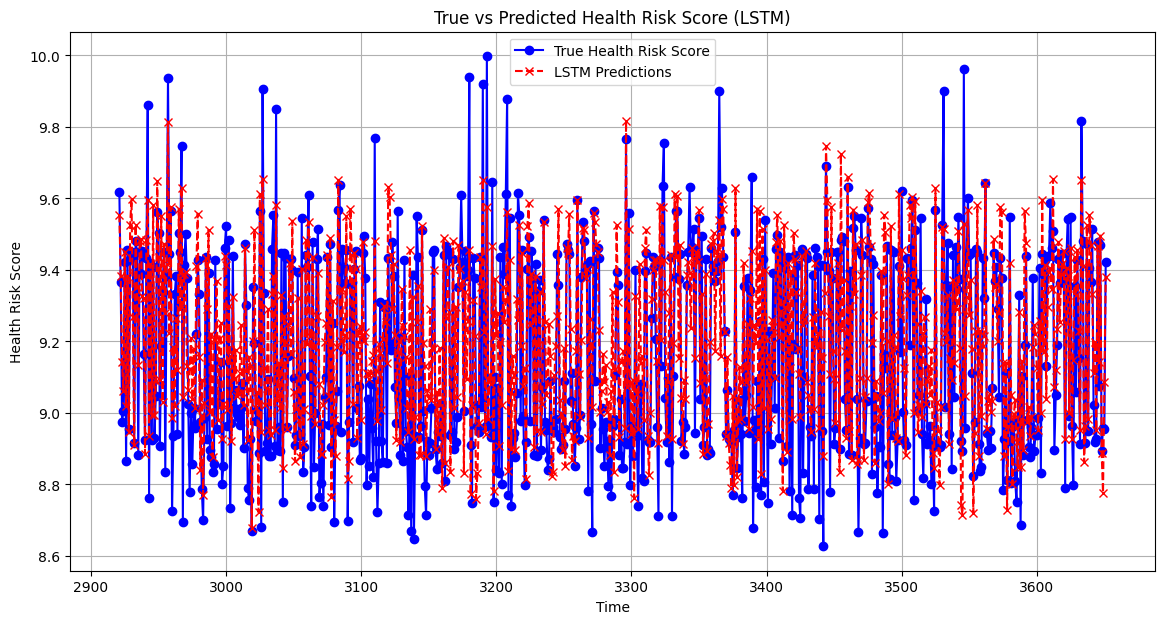

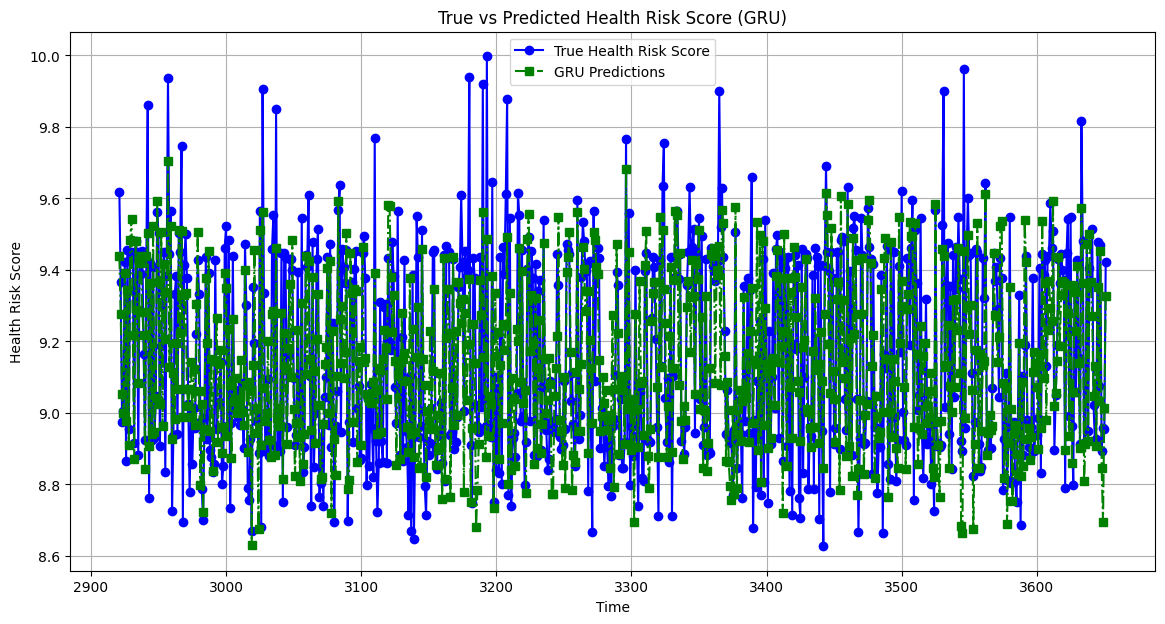

In [ ]:
#LSTM과 GRU 모델 제작
url = 'https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/refs/heads/main/Seoul%2014%7E23.csv'
df = pd.read_csv(url)
features = ['temp', 'tempmin', 'tempmax', 'precip', 'windgust', 'winddir', 'windspeed', 'dew',
            'humidity', 'pressure', 'solarradiation', 'snow', 'Temp_Range', 'feelslike',
            'feelslikemax']
target = 'Predicted_Health_Risk_Score'
df = df.dropna()
X = df[features]
y = df[target]
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model
def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model
lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
gru_model = create_gru_model((X_train.shape[1], X_train.shape[2]))
gru_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
y_pred_lstm = lstm_model.predict(X_test)
y_pred_gru = gru_model.predict(X_test)
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm)
y_pred_gru = scaler_y.inverse_transform(y_pred_gru)
y_test = scaler_y.inverse_transform(y_test)
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2
lstm_metrics = calculate_metrics(y_test, y_pred_lstm)
gru_metrics = calculate_metrics(y_test, y_pred_gru)
metrics_df = pd.DataFrame({
    "Model": ["LSTM", "GRU"],
    "MAE": [lstm_metrics[0], gru_metrics[0]],
    "MSE": [lstm_metrics[1], gru_metrics[1]],
    "RMSE": [lstm_metrics[2], gru_metrics[2]],
})

print(metrics_df)

plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='True Health Risk Score', color='blue', linestyle='-', marker='o')
plt.plot(df.index[-len(y_test):], y_pred_lstm, label='LSTM Predictions', color='red', linestyle='--', marker='x')
plt.title('True vs Predicted Health Risk Score (LSTM)')
plt.xlabel('Time')
plt.ylabel('Health Risk Score')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='True Health Risk Score', color='blue', linestyle='-', marker='o')
plt.plot(df.index[-len(y_test):], y_pred_gru, label='GRU Predictions', color='green', linestyle='-.', marker='s')
plt.title('True vs Predicted Health Risk Score (GRU)')
plt.xlabel('Time')
plt.ylabel('Health Risk Score')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


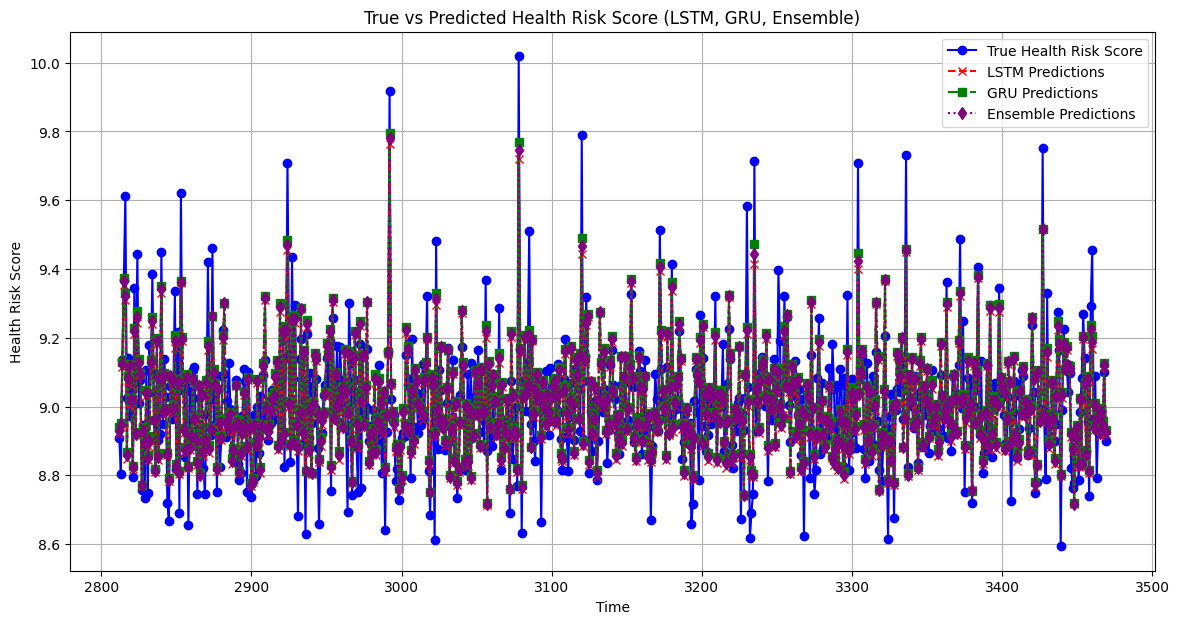

      Model       MAE       MSE      RMSE        R2
0      LSTM  0.078280  0.010978  0.104775  0.667594
1       GRU  0.079020  0.010730  0.103585  0.675104
2  ENSEMBLE  0.078305  0.010785  0.103850  0.673441


In [ ]:
#계절성 및 트렌드 분리
url = "https://github.com/0jin03/0jin03/blob/main/seoul2.xlsx?raw=true"
df = pd.read_excel(url, engine='openpyxl')
decomposition = seasonal_decompose(df['Predicted_Health_Risk_Score'], model='multiplicative', period=365)
trend = decomposition.trend.dropna()
seasonal = decomposition.seasonal.dropna()
df['trend'] = trend
df['seasonal'] = seasonal
df = df.dropna()
features = ['temp', 'tempmin', 'tempmax', 'precip', 'windgust', 'winddir', 'windspeed', 'dew',
            'humidity', 'pressure', 'solarradiation', 'snow', 'Temp_Range', 'feelslike',
            'feelslikemax', 'trend', 'seasonal']
target = 'Predicted_Health_Risk_Score'
X = df[features]
y = df[target]
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model
lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model
gru_model = create_gru_model((X_train.shape[1], X_train.shape[2]))
gru_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
y_pred_lstm = lstm_model.predict(X_test)
y_pred_gru = gru_model.predict(X_test)
ensemble_pred = (y_pred_lstm + y_pred_gru) / 2
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm)
y_pred_gru = scaler_y.inverse_transform(y_pred_gru)
ensemble_pred = scaler_y.inverse_transform(ensemble_pred)
y_test = scaler_y.inverse_transform(y_test)

plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='True Health Risk Score', color='blue', linestyle='-', marker='o')
plt.plot(df.index[-len(y_test):], y_pred_lstm, label='LSTM Predictions', color='red', linestyle='--', marker='x')
plt.plot(df.index[-len(y_test):], y_pred_gru, label='GRU Predictions', color='green', linestyle='-.', marker='s')
plt.plot(df.index[-len(y_test):], ensemble_pred, label='Ensemble Predictions', color='purple', linestyle=':', marker='d')
plt.title('True vs Predicted Health Risk Score (LSTM, GRU, Ensemble)')
plt.xlabel('Time')
plt.ylabel('Health Risk Score')
plt.legend()
plt.grid(True)
plt.show()


def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mae, mse, rmse
lstm_metrics = calculate_metrics(y_test, y_pred_lstm)
gru_metrics = calculate_metrics(y_test, y_pred_gru)
ensemble_metrics = calculate_metrics(y_test, ensemble_pred)
metrics_df = pd.DataFrame({
    "Model": ["LSTM", "GRU","ENSEMBLE"],
    "MAE": [lstm_metrics[0], gru_metrics[0],ensemble_metrics[0]],
    "MSE": [lstm_metrics[1], gru_metrics[1],ensemble_metrics[1]],
    "RMSE": [lstm_metrics[2], gru_metrics[2],ensemble_metrics[2]]
})

print(metrics_df)

In [ ]:
#하이퍼파라미터 튜닝
url = "https://github.com/0jin03/0jin03/blob/main/seoul2.xlsx?raw=true"
df = pd.read_excel(url, engine='openpyxl')
features = ['temp', 'tempmin', 'tempmax', 'precip', 'windgust', 'winddir', 'windspeed', 'dew',
            'humidity', 'pressure', 'solarradiation', 'snow', 'Temp_Range', 'feelslike',
            'feelslikemax']
target = 'Predicted_Health_Risk_Score'
df = df.dropna()
X = df[features]
y = df[target]
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
units_options = [50, 100, 150]
dropout_rate_options = [0.2, 0.3, 0.4]
best_mse = float('inf')
best_r2 = -float('inf')
best_params = {}
for units in units_options:
    for dropout_rate in dropout_rate_options:
        model = Sequential()
        model.add(LSTM(units=units, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        print(f"Units: {units}, Dropout Rate: {dropout_rate}, MSE: {mse}")
        if mse < best_mse:
            best_mse = mse
            best_r2 = r2
            best_params = {'units': units, 'dropout_rate': dropout_rate}
print(f"Best Params: {best_params}, Best MSE: {best_mse}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Units: 50, Dropout Rate: 0.2, MSE: 0.005731354937303763, R-squared: 0.6078676255244172


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Units: 50, Dropout Rate: 0.3, MSE: 0.005947090185025185, R-squared: 0.5931072807416394


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Units: 50, Dropout Rate: 0.4, MSE: 0.00588137839227338, R-squared: 0.5976032021432434


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Units: 100, Dropout Rate: 0.2, MSE: 0.005817981779808627, R-squared: 0.6019407217091154


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Units: 100, Dropout Rate: 0.3, MSE: 0.005779363271865977, R-squared: 0.6045829533251841


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Units: 100, Dropout Rate: 0.4, MSE: 0.005886779639181271, R-squared: 0.5972336553609747


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Units: 150, Dropout Rate: 0.2, MSE: 0.005623637166284646, R-squared: 0.6152375451655858


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Units: 150, Dropout Rate: 0.3, MSE: 0.005844187395600275, R-squared: 0.6001477651643916


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Units: 150, Dropout Rate: 0.4, MSE: 0.005697979537894816, R-squared: 0.6101511299945588
Best Params: {'units': 150, 'dropout_rate': 0.2}, Best MSE: 0.005623637166284646, Best R-squared: 0.6152375451655858


##5.2 14~22년 데이터 기준으로 23년 데이터 예측

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Model      MAE       MSE      RMSE        R2
0  LSTM  0.07324  0.008570  0.092575  0.680038
1   GRU  0.07625  0.009223  0.096036  0.655666


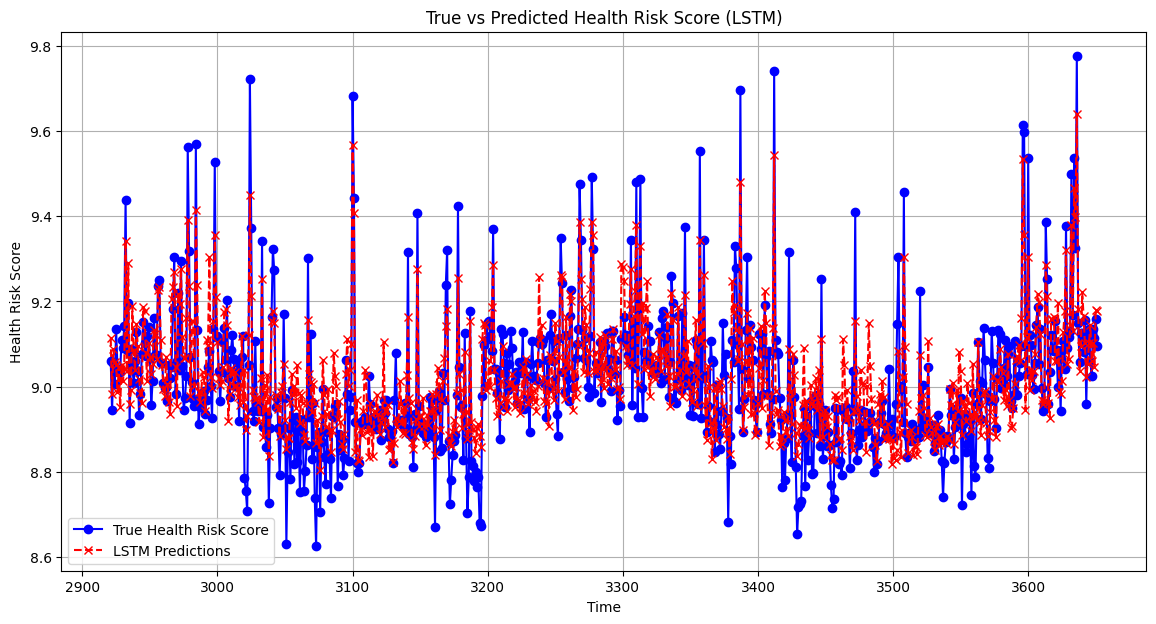

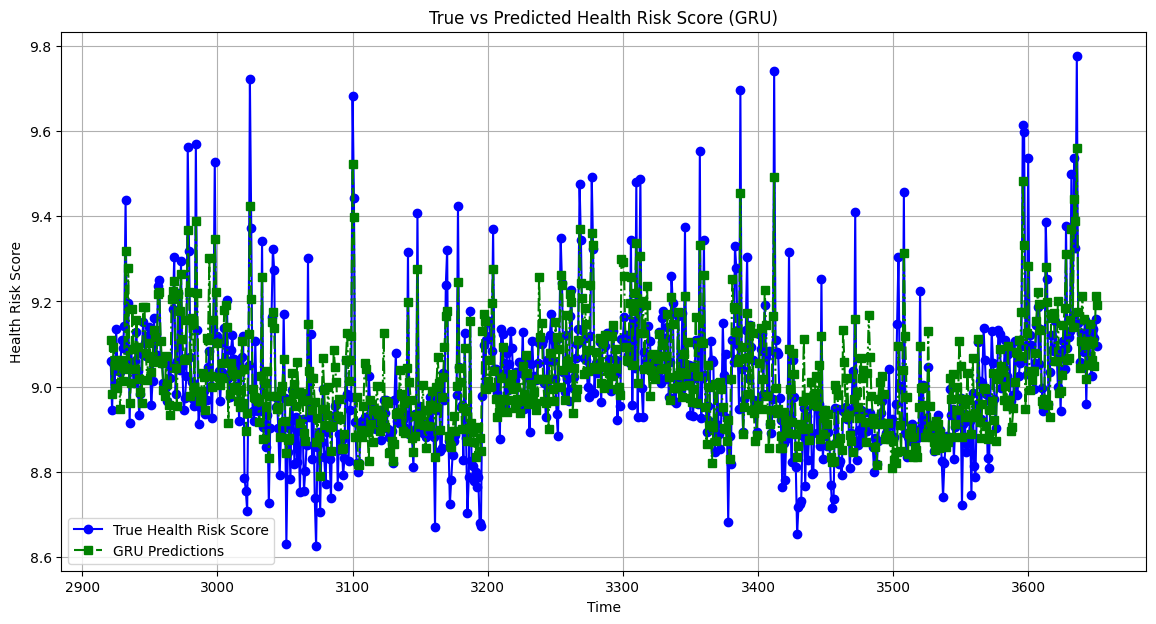

In [3]:
#LSTM과 GRU 모델 제작
url = "https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/refs/heads/main/seoul2.csv"
df = pd.read_csv(url)
features = ['temp', 'tempmin', 'tempmax', 'precip', 'windgust', 'winddir', 'windspeed', 'dew',
            'humidity', 'pressure', 'solarradiation', 'snow', 'Temp_Range', 'feelslike',
            'feelslikemax']
target = 'Predicted_Health_Risk_Score'
df = df.dropna()
X = df[features]
y = df[target]
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model
def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model
lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
gru_model = create_gru_model((X_train.shape[1], X_train.shape[2]))
gru_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
y_pred_lstm = lstm_model.predict(X_test)
y_pred_gru = gru_model.predict(X_test)
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm)
y_pred_gru = scaler_y.inverse_transform(y_pred_gru)
y_test = scaler_y.inverse_transform(y_test)
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2
lstm_metrics = calculate_metrics(y_test, y_pred_lstm)
gru_metrics = calculate_metrics(y_test, y_pred_gru)
metrics_df = pd.DataFrame({
    "Model": ["LSTM", "GRU"],
    "MAE": [lstm_metrics[0], gru_metrics[0]],
    "MSE": [lstm_metrics[1], gru_metrics[1]],
    "RMSE": [lstm_metrics[2], gru_metrics[2]],
    "R2": [lstm_metrics[3], gru_metrics[3]]
})

print(metrics_df)

plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='True Health Risk Score', color='blue', linestyle='-', marker='o')
plt.plot(df.index[-len(y_test):], y_pred_lstm, label='LSTM Predictions', color='red', linestyle='--', marker='x')
plt.title('True vs Predicted Health Risk Score (LSTM)')
plt.xlabel('Time')
plt.ylabel('Health Risk Score')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='True Health Risk Score', color='blue', linestyle='-', marker='o')
plt.plot(df.index[-len(y_test):], y_pred_gru, label='GRU Predictions', color='green', linestyle='-.', marker='s')
plt.title('True vs Predicted Health Risk Score (GRU)')
plt.xlabel('Time')
plt.ylabel('Health Risk Score')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
      Model       MAE       MSE      RMSE        R2
0      LSTM  0.066753  0.007566  0.086980  0.718128
1       GRU  0.073055  0.008899  0.094335  0.668446
2  ENSEMBLE  0.068867  0.008018  0.089541  0.701287


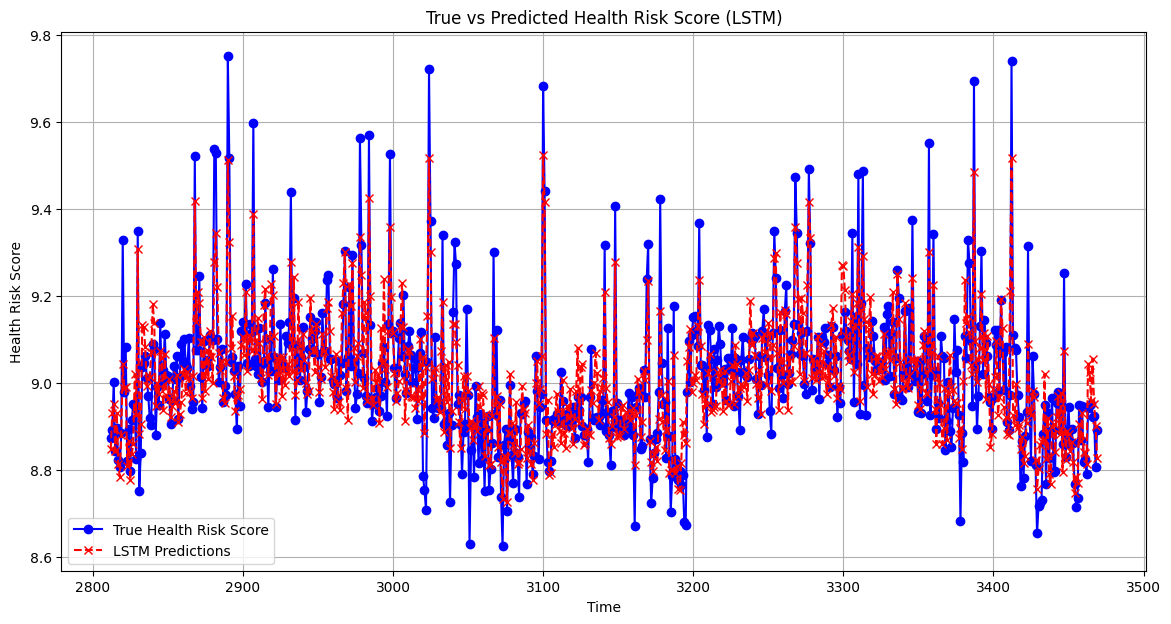

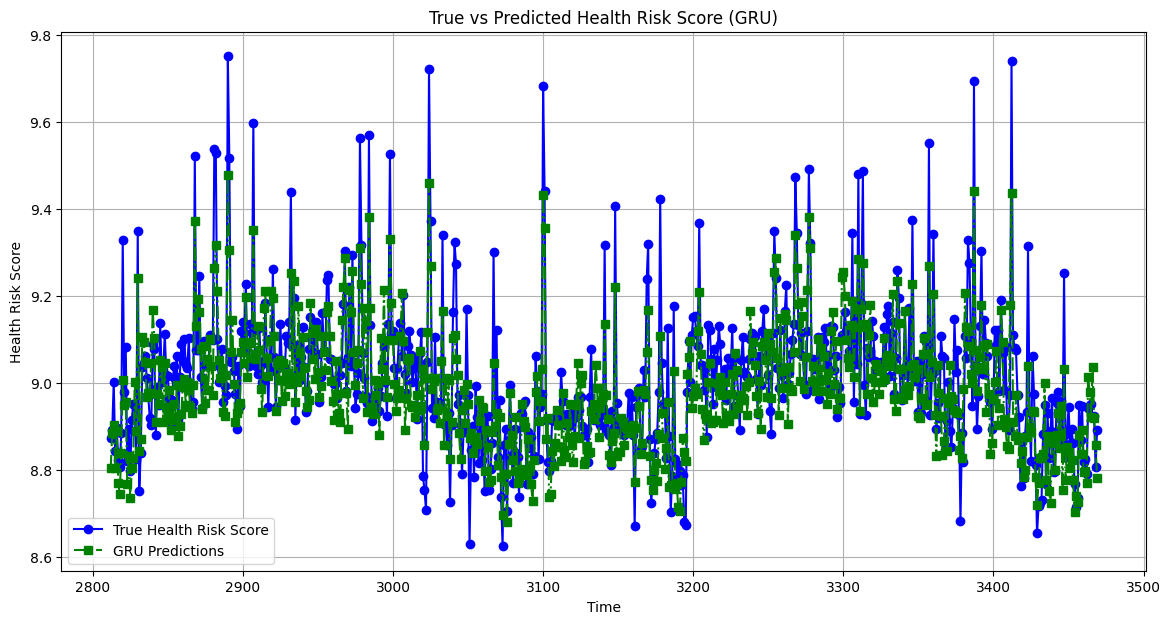

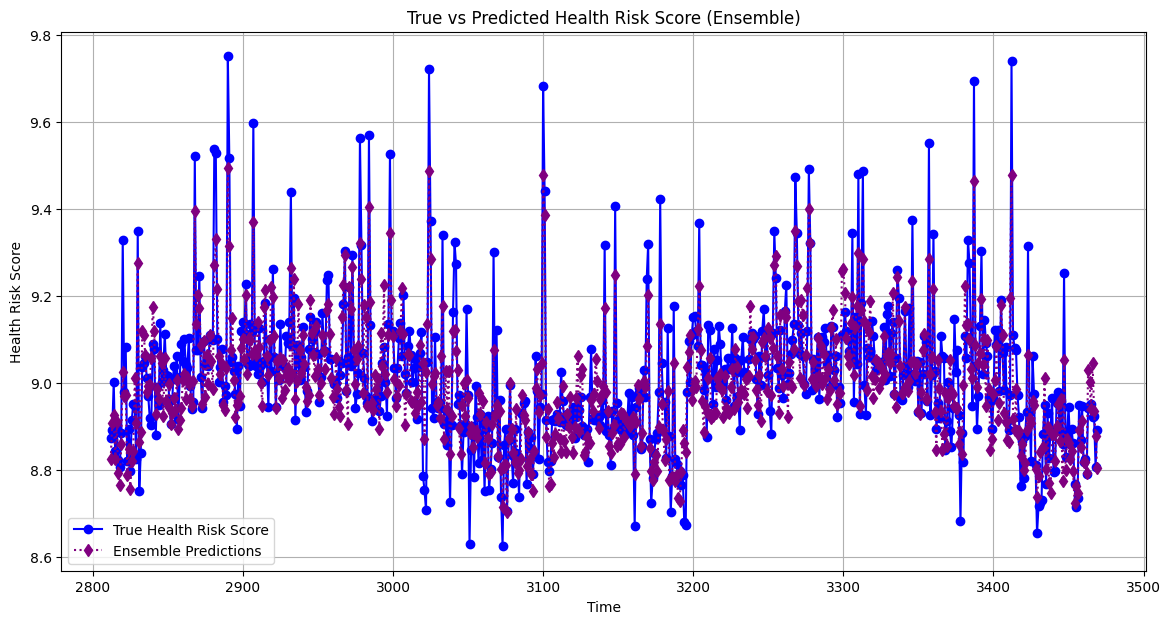

In [4]:
#계절성 및 트렌드 분리
url = "https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/refs/heads/main/seoul2.csv"
df = pd.read_csv(url)
decomposition = seasonal_decompose(df['Predicted_Health_Risk_Score'], model='multiplicative', period=365)
trend = decomposition.trend.dropna()
seasonal = decomposition.seasonal.dropna()
df['trend'] = trend
df['seasonal'] = seasonal
df = df.dropna()
features = ['temp', 'tempmin', 'tempmax', 'precip', 'windgust', 'winddir', 'windspeed', 'dew',
            'humidity', 'pressure', 'solarradiation', 'snow', 'Temp_Range', 'feelslike',
            'feelslikemax', 'trend', 'seasonal']
target = 'Predicted_Health_Risk_Score'
X = df[features]
y = df[target]
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model
lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model
gru_model = create_gru_model((X_train.shape[1], X_train.shape[2]))
gru_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
y_pred_lstm = lstm_model.predict(X_test)
y_pred_gru = gru_model.predict(X_test)
ensemble_pred = (y_pred_lstm + y_pred_gru) / 2
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm)
y_pred_gru = scaler_y.inverse_transform(y_pred_gru)
ensemble_pred = scaler_y.inverse_transform(ensemble_pred)
y_test = scaler_y.inverse_transform(y_test)

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2
lstm_metrics = calculate_metrics(y_test, y_pred_lstm)
gru_metrics = calculate_metrics(y_test, y_pred_gru)
ensemble_metrics = calculate_metrics(y_test, ensemble_pred)
import pandas as pd
metrics_df = pd.DataFrame({
    "Model": ["LSTM", "GRU","ENSEMBLE"],
    "MAE": [lstm_metrics[0], gru_metrics[0],ensemble_metrics[0]],
    "MSE": [lstm_metrics[1], gru_metrics[1],ensemble_metrics[1]],
    "RMSE": [lstm_metrics[2], gru_metrics[2],ensemble_metrics[2]],
    "R2": [lstm_metrics[3], gru_metrics[3],ensemble_metrics[3]]
})
print(metrics_df)

plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='True Health Risk Score', color='blue', linestyle='-', marker='o')
plt.plot(df.index[-len(y_test):], y_pred_lstm, label='LSTM Predictions', color='red', linestyle='--', marker='x')
plt.title('True vs Predicted Health Risk Score (LSTM)')
plt.xlabel('Time')
plt.ylabel('Health Risk Score')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='True Health Risk Score', color='blue', linestyle='-', marker='o')
plt.plot(df.index[-len(y_test):], y_pred_gru, label='GRU Predictions', color='green', linestyle='-.', marker='s')
plt.title('True vs Predicted Health Risk Score (GRU)')
plt.xlabel('Time')
plt.ylabel('Health Risk Score')
plt.legend()
plt.grid(True)
plt.show()
ensemble_pred = (y_pred_lstm + y_pred_gru) / 2
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='True Health Risk Score', color='blue', linestyle='-', marker='o')
plt.plot(df.index[-len(y_test):], ensemble_pred, label='Ensemble Predictions', color='purple', linestyle=':', marker='d')
plt.title('True vs Predicted Health Risk Score (Ensemble)')
plt.xlabel('Time')
plt.ylabel('Health Risk Score')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
#하이퍼파라미터 튜닝
url = "https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/refs/heads/main/seoul2.csv"
df = pd.read_csv(url)
features = ['temp', 'tempmin', 'tempmax', 'precip', 'windgust', 'winddir', 'windspeed', 'dew',
            'humidity', 'pressure', 'solarradiation', 'snow', 'Temp_Range', 'feelslike',
            'feelslikemax']
target = 'Predicted_Health_Risk_Score'
df = df.dropna()
X = df[features]
y = df[target]
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]
units_options = [50, 100, 150]
dropout_rate_options = [0.2, 0.3, 0.4]
best_mse = float('inf')
best_r2 = -float('inf')
best_params = {}
for units in units_options:
    for dropout_rate in dropout_rate_options:
        model = Sequential()
        model.add(LSTM(units=units, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"Units: {units}, Dropout Rate: {dropout_rate}, MSE: {mse}, R-squared: {r2}")
        if mse < best_mse:
            best_mse = mse
            best_r2 = r2
            best_params = {'units': units, 'dropout_rate': dropout_rate}
print(f"Best Params: {best_params}, Best MSE: {best_mse}, Best R-squared: {best_r2}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Units: 50, Dropout Rate: 0.2, MSE: 0.0042367616093533225, R-squared: 0.6700117184841924


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Units: 50, Dropout Rate: 0.3, MSE: 0.004207800109371688, R-squared: 0.6722674403043583


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Units: 50, Dropout Rate: 0.4, MSE: 0.004307219525871009, R-squared: 0.6645239688927291


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Units: 100, Dropout Rate: 0.2, MSE: 0.0045981050954737555, R-squared: 0.6418677899330618


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Units: 100, Dropout Rate: 0.3, MSE: 0.004142340629539132, R-squared: 0.6773658770941877


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Units: 100, Dropout Rate: 0.4, MSE: 0.0047404542464606625, R-squared: 0.6307806540400009


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Units: 150, Dropout Rate: 0.2, MSE: 0.004010161250016002, R-squared: 0.6876609208852689


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Units: 150, Dropout Rate: 0.3, MSE: 0.004154656879142868, R-squared: 0.6764066024367502


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Units: 150, Dropout Rate: 0.4, MSE: 0.004254515912105831, R-squared: 0.6686288906560045
Best Params: {'units': 150, 'dropout_rate': 0.2}, Best MSE: 0.004010161250016002, Best R-squared: 0.6876609208852689


#6 전국 health risk score 분석

In [ ]:
#전국 health_risk_score 분석
urls = {
    'Chuncheon': "https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/refs/heads/main/Chuncheon2.csv",
    'Yeosu': "https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/refs/heads/main/yeosu2.csv",
    'Daejeon': "https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/refs/heads/main/Daejeon2.csv",
    'Busan': "https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/refs/heads/main/Busan2.csv",
    'Seoul': "https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/refs/heads/main/seoul2.csv",
    'Cheongju': "https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/refs/heads/main/Cheogju2.csv",
    'Jeonju': "https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/refs/heads/main/Jeonju002.csv",
    'Gwangju': "https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/refs/heads/main/Gwangju002.csv",
    'Daegu': "https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/refs/heads/main/Daegu2.csv",
    'Baekryungdo': "https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/refs/heads/main/Baekryungdo2.csv",
    'Suwon': "https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/refs/heads/main/suwon2.csv",
    'Ulsan': "https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/refs/heads/main/ulsan2.csv",
    'Andong': "https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/refs/heads/main/Andong2.csv",
    'Jeju': "https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/refs/heads/main/jeju002.csv",
    'Ulrung': "https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/refs/heads/main/ulrung2.csv",
    'Mokpo': "https://raw.githubusercontent.com/rich-hyun/5th-Static-Competition/refs/heads/main/Mokpo002.csv"
}
# 각 파일을 불러와서 해당 변수에 저장
Chuncheon = pd.read_csv(urls['Chuncheon'])
Yeosu = pd.read_csv(urls['Yeosu'])
Daejeon = pd.read_csv(urls['Daejeon'])
Busan = pd.read_csv(urls['Busan'])
Seoul = pd.read_csv(urls['Seoul'])
Cheongju = pd.read_csv(urls['Cheongju'])
Jeonju = pd.read_csv(urls['Jeonju'])
Gwangju = pd.read_csv(urls['Gwangju'])
Daegu = pd.read_csv(urls['Daegu'])
Baekryungdo = pd.read_csv(urls['Baekryungdo'])
Suwon = pd.read_csv(urls['Suwon'])
Ulsan = pd.read_csv(urls['Ulsan'])
Andong = pd.read_csv(urls['Andong'])
Jeju = pd.read_csv(urls['Jeju'])
Ulrung = pd.read_csv(urls['Ulrung'])
Mokpo = pd.read_csv(urls['Mokpo'])

print(Chuncheon.head())

     datatime   temp  tempmin  tempmax  precip   windgust  winddir  windspeed  \
0  2014-01-01  39.20    29.84    44.96     0.0  12.526864      230   5.816044   
1  2014-01-02  32.54    22.28    46.04     0.0   6.487126      230   2.236940   
2  2014-01-03  29.84    23.00    41.36     0.0   3.802798      360   1.342164   
3  2014-01-04  32.54    22.82    43.34     0.0   4.921268       70   1.789552   
4  2014-01-05  31.10    24.62    39.92     0.0   7.158208      340   1.789552   

   dew  humiditymin  humidity  pressure  solarradiation      snow  Temp_Range  \
0 -5.7         33.0      49.6    1003.9     2030.555557  1.299213       15.12   
1 -9.5         20.0      53.8    1011.3     2538.888891  0.748032       23.76   
2 -5.4         37.0      74.5    1008.2     1652.777779  0.393701       18.36   
3 -3.4         49.0      78.1    1009.8     2155.555557  0.000000       20.52   
4 -4.4         40.0      77.4    1014.0     1766.666668  0.000000       15.30   

   feelslike  feelslikemax

In [ ]:
# 'Predicted_Health_Risk_Score' 컬럼의 평균 구하기
uploaded = files.upload()
df_uploaded = pd.read_excel(list(uploaded.keys())[0], sheet_name='Sheet1')
mean_health_risk_score = df_uploaded['Predicted_Health_Risk_Score'].mean()
print(f"Predicted Health Risk Score의 평균: {mean_health_risk_score}")

<Figure size 1000x600 with 0 Axes>

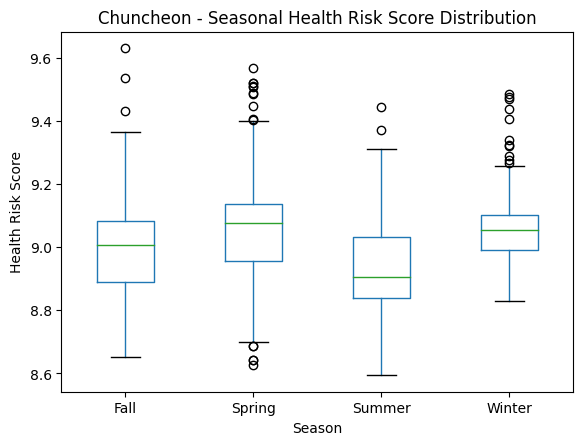

In [ ]:
# Chuncheon 데이터 박스화
def process_seasonal_health_risk(data, region_name):
    data['datatime'] = pd.to_datetime(data['datatime'])
    data['Month'] = data['datatime'].dt.month
    # 봄: 3-5월, 여름: 6-8월, 가을: 9-11월, 겨울: 12, 1, 2월
    data['Season'] = data['Month'].apply(lambda x: 'Spring' if x in [3, 4, 5] else
                                                     'Summer' if x in [6, 7, 8] else
                                                     'Fall' if x in [9, 10, 11] else 'Winter')

    plt.figure(figsize=(10, 6))
    data.boxplot(column='Predicted_Health_Risk_Score', by='Season')
    plt.title(f'{region_name} - Seasonal Health Risk Score Distribution')
    plt.suptitle('')
    plt.xlabel('Season')
    plt.ylabel('Health Risk Score')
    plt.grid(False)
    plt.show()

process_seasonal_health_risk(Chuncheon, 'Chuncheon')

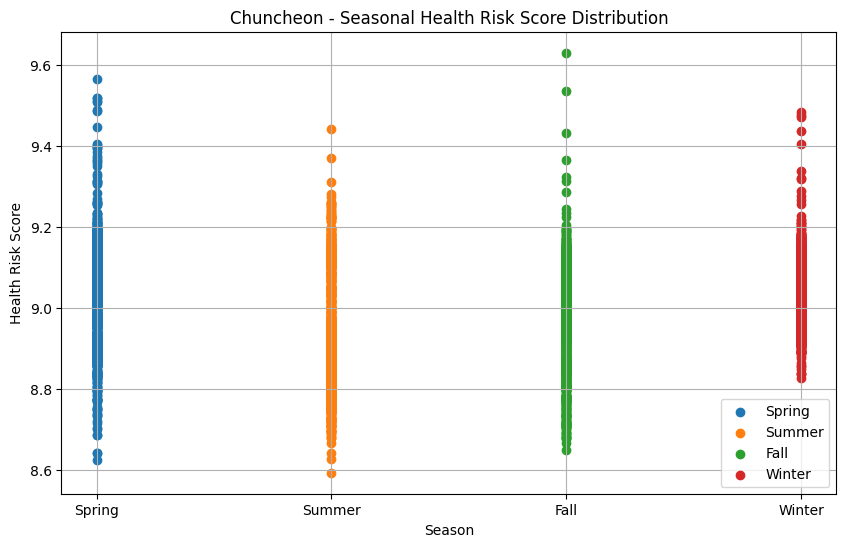

In [ ]:
# Chuncheon 계절별 산점도
def process_seasonal_health_risk(data, region_name):
    data['datatime'] = pd.to_datetime(data['datatime'])
    data['Month'] = data['datatime'].dt.month
    data['Season'] = data['Month'].apply(lambda x: 'Spring' if x in [3, 4, 5] else
                                                     'Summer' if x in [6, 7, 8] else
                                                     'Fall' if x in [9, 10, 11] else 'Winter')
    plt.figure(figsize=(10, 6))
    seasons = ['Spring', 'Summer', 'Fall', 'Winter']
    for season in seasons:
        season_data = data[data['Season'] == season]
        plt.scatter([season]*len(season_data), season_data['Predicted_Health_Risk_Score'], label=season)

    plt.title(f'{region_name} - Seasonal Health Risk Score Distribution')
    plt.xlabel('Season')
    plt.ylabel('Health Risk Score')
    plt.legend()
    plt.grid(True)
    plt.show()
process_seasonal_health_risk(Chuncheon, 'Chuncheon')

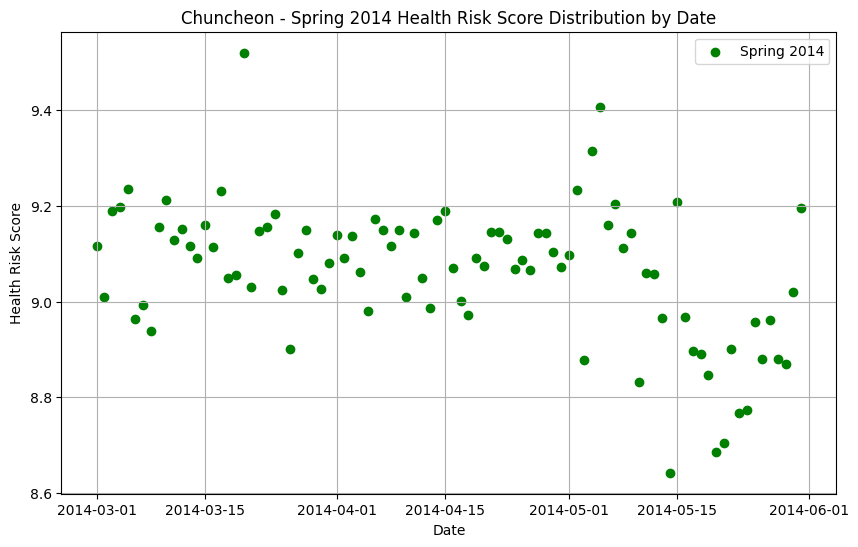

In [ ]:
#2014년 봄 Chuncheon 산점도
def process_spring_2014_health_risk(data, region_name):
    data['datatime'] = pd.to_datetime(data['datatime'])
    spring_2014_data = data[(data['datatime'].dt.year == 2014) & (data['datatime'].dt.month.isin([3, 4, 5]))]
    plt.figure(figsize=(10, 6))
    plt.scatter(spring_2014_data['datatime'], spring_2014_data['Predicted_Health_Risk_Score'], color='green', label='Spring 2014')
    plt.title(f'{region_name} - Spring 2014 Health Risk Score Distribution by Date')
    plt.xlabel('Date')
    plt.ylabel('Health Risk Score')
    plt.grid(True)
    plt.legend()
    plt.show()
process_spring_2014_health_risk(Chuncheon, 'Chuncheon')

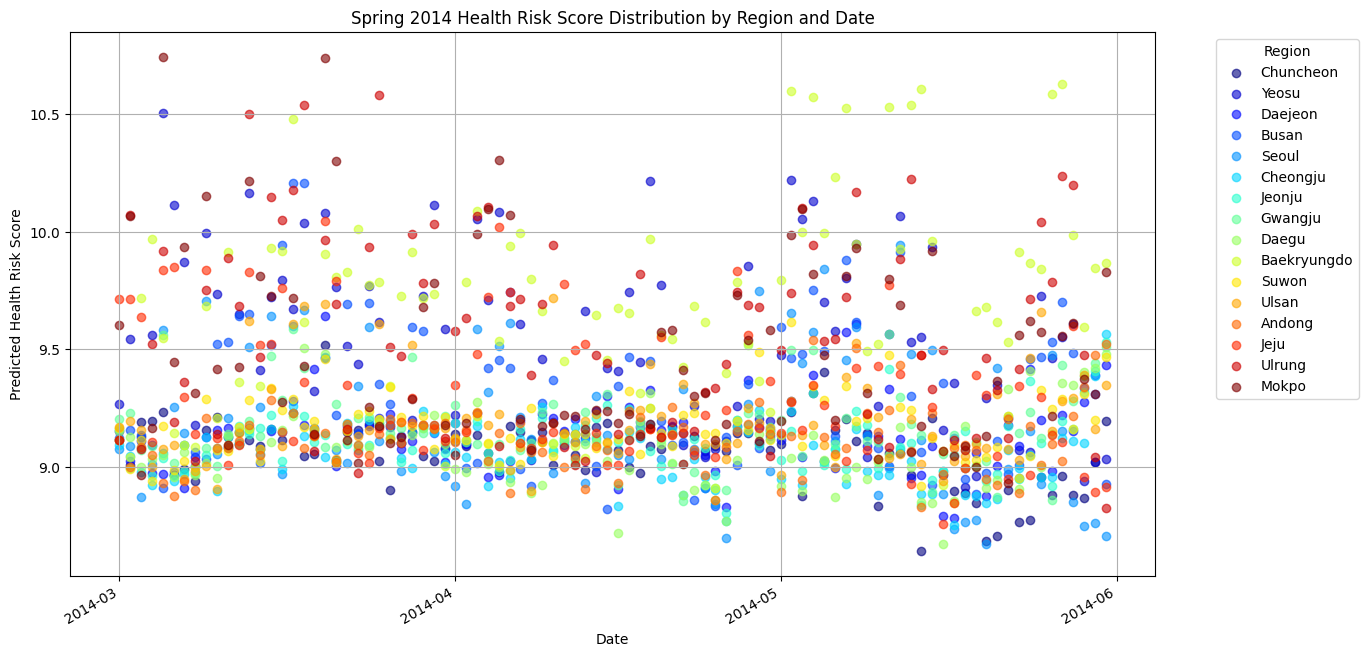

In [ ]:
# 각 지역별로 2014년 봄 데이터 필터링 및 산점도 시각화
dataframes = {
    'Chuncheon': Chuncheon,
    'Yeosu': Yeosu,
    'Daejeon': Daejeon,
    'Busan': Busan,
    'Seoul': Seoul,
    'Cheongju': Cheongju,
    'Jeonju': Jeonju,
    'Gwangju': Gwangju,
    'Daegu': Daegu,
    'Baekryungdo': Baekryungdo,
    'Suwon': Suwon,
    'Ulsan': Ulsan,
    'Andong': Andong,
    'Jeju': Jeju,
    'Ulrung': Ulrung,
    'Mokpo': Mokpo
}
colors = plt.cm.jet(np.linspace(0, 1, len(dataframes)))
plt.figure(figsize=(14, 8))
for (region, df), color in zip(dataframes.items(), colors):
    df['datatime'] = pd.to_datetime(df['datatime'], errors='coerce')
    spring_2014_data = df[(df['datatime'].dt.year == 2014) & (df['datatime'].dt.month.isin([3, 4, 5]))]
    plt.scatter(spring_2014_data['datatime'], spring_2014_data['Predicted_Health_Risk_Score'], color=color, label=region, alpha=0.6)
plt.title('Spring 2014 Health Risk Score Distribution by Region and Date')
plt.xlabel('Date')
plt.ylabel('Predicted Health Risk Score')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
#년도별 계절별 health risk score 평균 정렬화
dataframes = {
    'Chuncheon': Chuncheon,
    'Yeosu': Yeosu,
    'Daejeon': Daejeon,
    'Busan': Busan,
    'Seoul': Seoul,
    'Cheongju': Cheongju,
    'Jeonju': Jeonju,
    'Gwangju': Gwangju,
    'Daegu': Daegu,
    'Baekryungdo': Baekryungdo,
    'Suwon': Suwon,
    'Ulsan': Ulsan,
    'Andong': Andong,
    'Jeju': Jeju,
    'Ulrung': Ulrung,
    'Mokpo': Mokpo
}
all_data = []
for region, df in dataframes.items():
    df['datatime'] = pd.to_datetime(df['datatime'])
    df['Year'] = df['datatime'].dt.year
    df['Month'] = df['datatime'].dt.month
    df['Season'] = df['Month'].apply(lambda x: 'Spring' if x in [3, 4, 5] else
                                              'Summer' if x in [6, 7, 8] else
                                              'Fall' if x in [9, 10, 11] else
                                              'Winter')
    df['Region'] = region
    all_data.append(df[['Year', 'Season', 'Region', 'Predicted_Health_Risk_Score']])
all_data_df = pd.concat(all_data)
seasonal_avg_risk = all_data_df.groupby(['Year', 'Season', 'Region']).mean().reset_index()
def print_sorted_risk_scores(seasonal_data):
    years = seasonal_data['Year'].unique()
    seasons = ['Spring', 'Summer', 'Fall', 'Winter']

    for year in sorted(years):
        for season in seasons:
            print(f"{year} {season}:")
            season_data = seasonal_data[(seasonal_data['Year'] == year) & (seasonal_data['Season'] == season)]
            season_data_sorted = season_data.sort_values(by='Predicted_Health_Risk_Score', ascending=False)
            for index, row in season_data_sorted.iterrows():
                print(f"{row['Region']}: {row['Predicted_Health_Risk_Score']:.2f}")
            print("-" * 50)
print_sorted_risk_scores(seasonal_avg_risk)

2014 Spring:
Baekryungdo: 9.68
Ulrung: 9.55
Yeosu: 9.51
Mokpo: 9.47
Jeju: 9.30
Busan: 9.27
Ulsan: 9.19
Seoul: 9.18
Suwon: 9.17
Gwangju: 9.17
Daejeon: 9.14
Andong: 9.12
Jeonju: 9.10
Daegu: 9.08
Chuncheon: 9.06
Cheongju: 9.05
--------------------------------------------------
2014 Summer:
Daejeon: 10.02
Suwon: 9.97
Jeonju: 9.96
Mokpo: 9.94
Ulsan: 9.91
Yeosu: 9.90
Cheongju: 9.89
Daegu: 9.86
Gwangju: 9.86
Andong: 9.63
Baekryungdo: 9.21
Ulrung: 9.17
Busan: 9.11
Jeju: 9.06
Seoul: 8.95
Chuncheon: 8.88
--------------------------------------------------
2014 Fall:
Yeosu: 9.52
Mokpo: 9.50
Baekryungdo: 9.38
Ulrung: 9.30
Ulsan: 9.27
Daejeon: 9.22
Gwangju: 9.21
Suwon: 9.20
Jeonju: 9.20
Jeju: 9.19
Daegu: 9.15
Andong: 9.15
Cheongju: 9.12
Busan: 9.09
Seoul: 9.01
Chuncheon: 8.98
--------------------------------------------------
2014 Winter:
Yeosu: 9.61
Mokpo: 9.55
Baekryungdo: 9.53
Ulrung: 9.53
Jeju: 9.49
Busan: 9.28
Ulsan: 9.17
Seoul: 9.12
Gwangju: 9.10
Andong: 9.10
Suwon: 9.08
Daegu: 9.08
Jeonju: 9.